# Produce lifetime XY map

### Run 5863: 17-06-2018 day
- pressure: 10 bar
- Gate voltage: 8 kV
- Low lifetime

### Notebook configuration

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [3]:
import os
import time
import collections
import glob

import tables            as tb
import numpy             as np

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string


from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [4]:
from core.kr_types import KrEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from   invisible_cities.evm  .ic_containers  import Measurement

In [5]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [6]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [7]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [8]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Mon Jun 18 12:19:41 2018


### Files

In [9]:
path = f"/Users/jjgomezcadenas/Projects/ICDEV/kdst"
run_number          = 5863
input_dst_filenames = f"{path}/{run_number}/kdst*.h5"
input_dst_filename  = f"{path}/{run_number}/kdst_{run_number}_s1s2.h5"

print(f"run number = {run_number}")
print(f"input dst = {input_dst_filename}")


run number = 5863
input dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5863/kdst_5863_s1s2.h5


In [10]:
output_dst_filename = f"{path}/{run_number}/kdst_{run_number}_map_lt.h5"
print(f"output dst = {output_dst_filename}")

output dst = /Users/jjgomezcadenas/Projects/ICDEV/kdst/5863/kdst_5863_map_lt.h5


### Read data

In [11]:
#dst = dstio.load_dsts(glob.glob(input_dst_filenames), "DST", "Events")
dst           = dstf.load_dst(input_dst_filename, "DST", "Events")
unique_events = ~dst.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 591947 
Total number of events: 591947


In [453]:
X = dst.X  .values
Y = dst.Y  .values
Z = dst.Z  .values
E = dst.S2e.values
Q = dst.S2q.values

krEvent = KrEvent(X = dst.X.values,
                  Y = dst.Y.values,
                  Z = dst.Z.values,
                  E = dst.S2e.values,
                  Q = dst.S2q.values)

### Ranges and binning

In [454]:
Zrange  =  100,  550
XYrange = -200,  200
Erange  =  2e3, 20e3
Qrange  =  100, 1500
Znbins  =   20
XYnbins =   20
Enbins  =  50
Qnbins  =  50

Zbins     = np.linspace(* Zrange,  Znbins + 1)
Ebins     = np.linspace(* Erange,  Enbins + 1)
Qbins     = np.linspace(* Qrange,  Qnbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)
XYpitch   = np.diff(XYbins)[0]

In [455]:
krNBins  = KrNBins(E = Enbins, Q = Qnbins, Z = Znbins, XY = XYnbins)
krRanges = KrRanges(E = Erange, Q = Qrange, Z = Zrange, XY = XYrange)
krBins   = KrBins(E = Ebins, Q = Qbins, Z = Zbins, XY = XYbins, cXY = XYcenters) 

### Event distribution

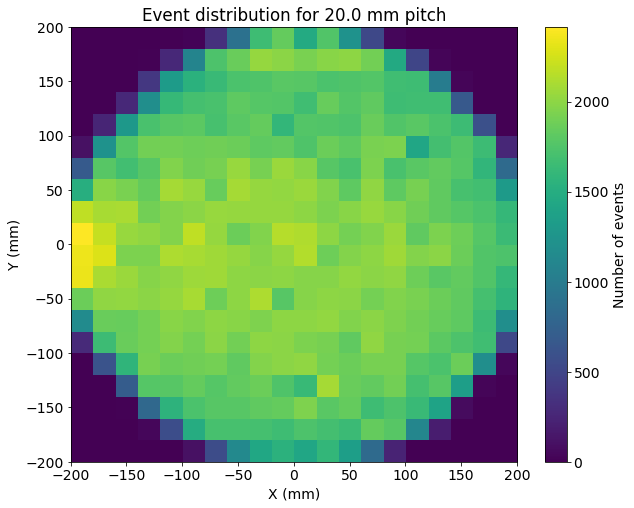

In [456]:
nevt, *_ = plt.hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"Event distribution for {XYpitch:.1f} mm pitch")

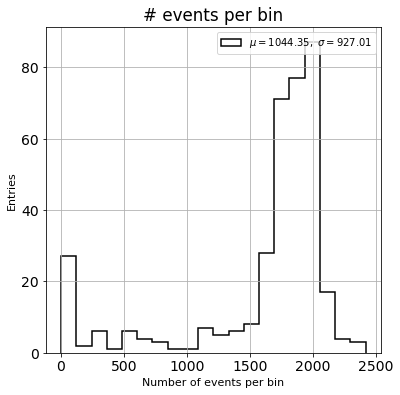

In [457]:
nevt_max = int(np.max(nevt))
mu, sigma = krh.h1d(nevt.flatten(), bins=20, range=(1, nevt_max + 2),
        xlabel='Number of events per bin', ylabel='Entries',
        title="# events per bin", legend = 'upper right',)

### Fit examples

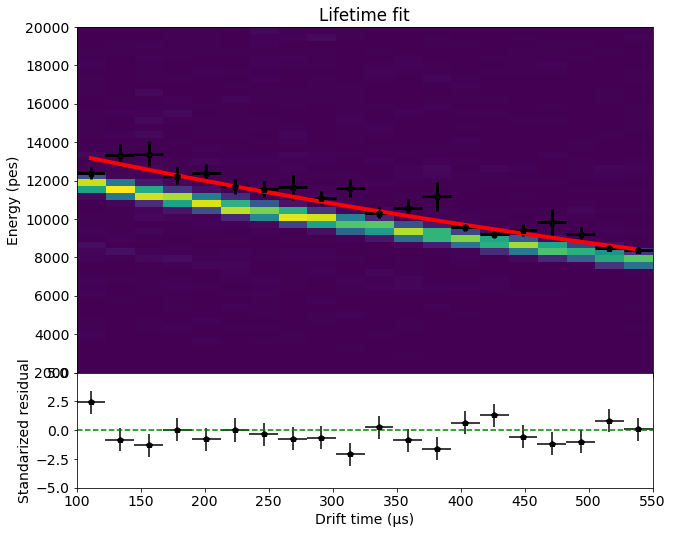

In [458]:
xlim =  -20, 20
ylim = -20, 20
xyr = XYRanges(X=xlim, Y=ylim )

kf = krf.lifetime_in_XYRange(krEvent, krNBins, krBins, krRanges, xyr)

In [459]:
krf.print_fit(kf)

 E (z=0) = 14796.270621321439 +-284.39396664306264 
 LT      = -953.6829165953044 +-44.18970512422717 
 chi2    = 0.9749542369945038 


xlim = (-125, -75), ylim =(-125, -75)
 E (z=0) = 13876.442714164372 +-224.81835877437942 
 LT      = -868.6363574473335 +-30.078854339338193 
 chi2    = 0.650867697302223 
xlim = (-125, -75), ylim =(75, 125)
 E (z=0) = 12622.614297675527 +-225.674774605164 
 LT      = -1031.6514751189936 +-59.34497326365352 
 chi2    = 0.8914589695821008 
xlim = (75, 125), ylim =(75, 125)
 E (z=0) = 11352.984059871964 +-150.9909441628054 
 LT      = -1462.1992848307393 +-89.42266856746633 
 chi2    = 1.1748775058392407 
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11283.468914751827 +-108.0747232898057 
 LT      = -1313.2693971922565 +-49.696628864143364 
 chi2    = 1.1169087908219497 


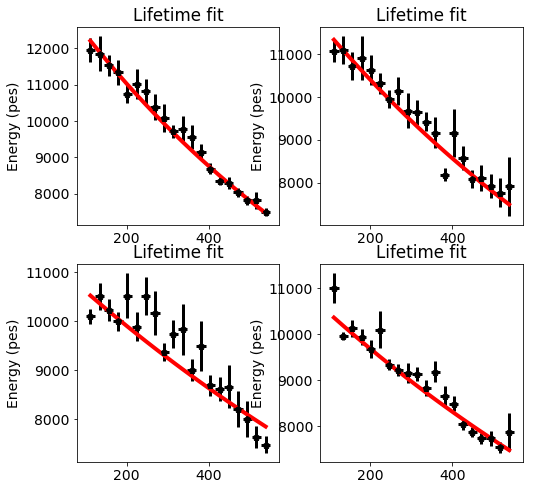

In [460]:
krf.lifetimes_in_XYRange(krEvent, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))

### Compute lifetime maps

In [461]:
krfs = krf.fit_lifetime_slices(krEvent, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [462]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [463]:
valid.shape

(20, 20)

In [464]:
np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])

0.7475

In [465]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =1189.8763441985445 +- 599.1534784248428
Lifetime uncertainty     : mu +- std =9.677874015435235 +- 8.110081289646251
Energy scale value       : mu +- std =12063.422576837129 +- 1597.6552639575473
Energy scale uncertainty : mu +- std =2.486533451488715 +- 0.9725838752485568


In [466]:
n_sigma  = 3
u_sigma  = 2
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 7270.456784964487; E_max = 16856.38836870977
 Lifetime (ELT): ELT_min = -607.5840910759837; ELT_max = 2987.336779473073
 Energy scale error (Eu): Eu_min = 0.5413657009916013; Eu_max = 4.431701201985828
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 25.898036594727735


### Map display

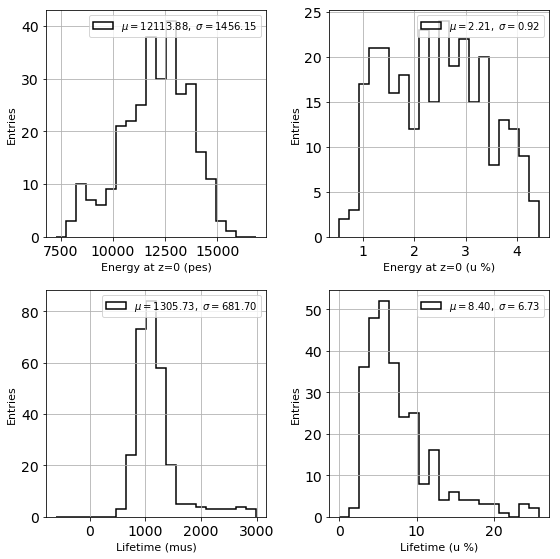

In [467]:
krh.h1d_4((Escale.value[valid],Escale.uncertainty[valid],
          ELT.value[valid],ELT.uncertainty[valid]),
          (20,20,20,20),
          (kltl.Es.interval,kltl.Eu.interval,kltl.LT.interval,kltl.LTu.interval),
          ('Energy at z=0 (pes)','Energy at z=0 (u %)','Lifetime (mus)', 'Lifetime (u %)'),
          ('Entries','Entries','Entries','Entries'),
          titles  =None,
          legends = ('best','best','best','best'),
          figsize =(8,8))


In [468]:
invalid = ~valid
mask = valid

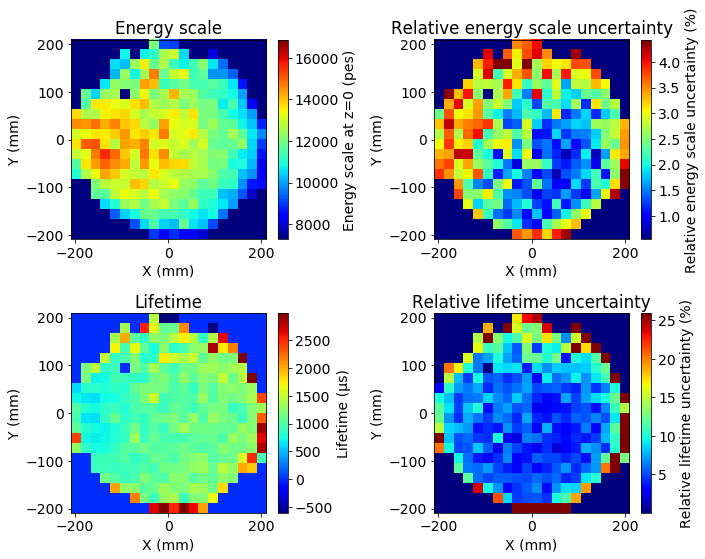

In [469]:
krp.display_lifetime_maps(Escale, ELT, kltl, XYcenters, cmap="jet", mask=valid)
                         

(1.5561539436403906, 0.77901972800809216)

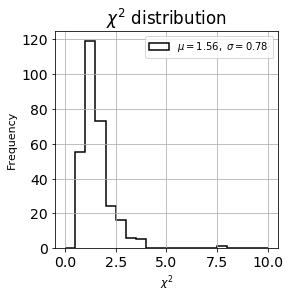

In [435]:
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

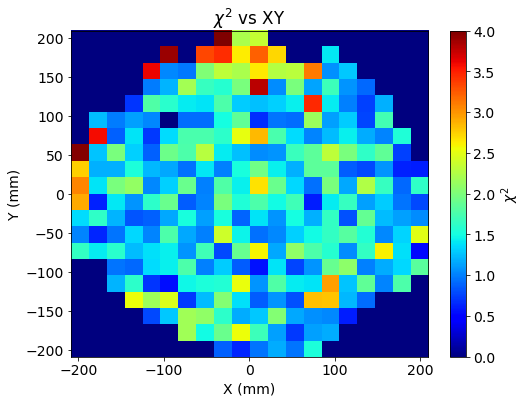

In [436]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(XYcenters, XYcenters, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

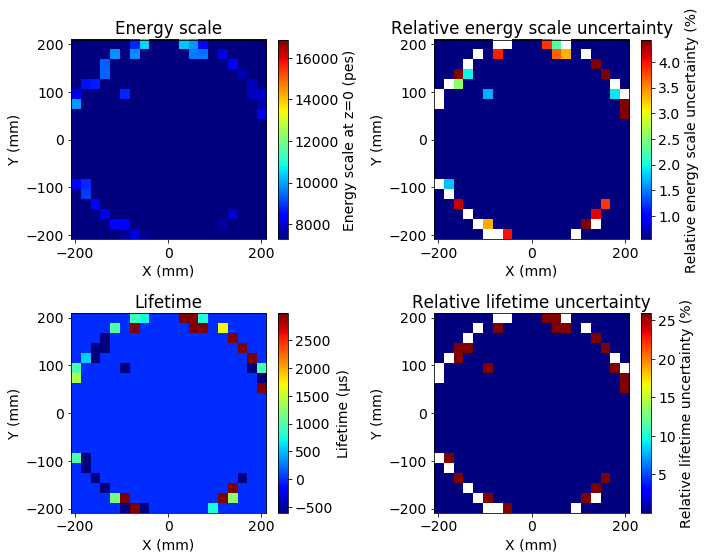

In [437]:
krp.display_lifetime_maps(Escale, ELT, kltl, XYcenters, cmap="jet", mask=invalid)

### Fix map

- Fill bins where fit has failed with average value of lifetime

In [438]:
Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value      ,     Es.mu), 
                     np.where(valid, Escale_abs.uncertainty,       Es.mu_u * Es.mu / 100 ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , El.mu), 
                  np.where(valid,  ELT_abs.uncertainty,    El.mu_u * El.mu / 100))

In [439]:
Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
ELT_corr        = to_relative(ELT_abs_corr, percentual=True)

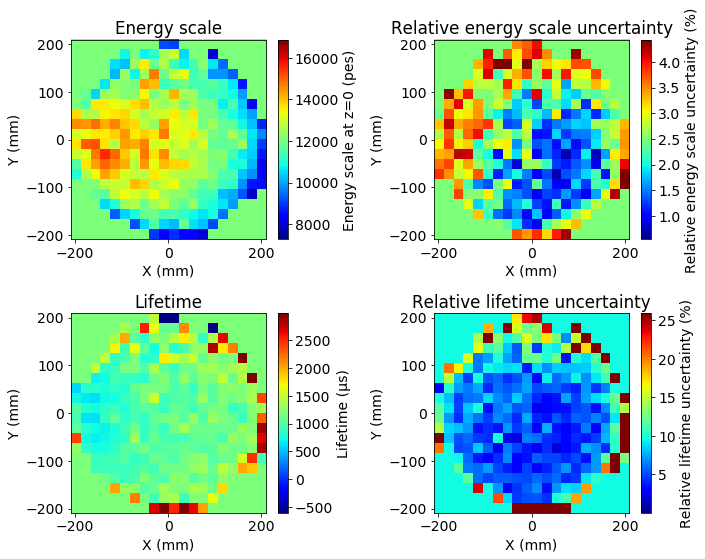

In [440]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, XYcenters, cmap="jet", mask=None)

### Produce HDF5 output

In [441]:
with tb.open_file(output_dst_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch



### END